# Partie C – Classification
- Dataset : Pima Indians Diabetes
- Objectif : Prédire la présence de diabète (étiquette binaire).
- Plan :
1. Chargement : utiliser le fichier diabetes.csv fourni.


In [3]:
import pandas as pd

# Chargement du fichier CSV
df = pd.read_csv('diabetes.csv')

# Aperçu des premières lignes
print(df.head())


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


2. Nettoyage et prétraitement
- Colonnes cliniques où 0 indique probablement une valeur manquante

In [6]:
import numpy as np

# Colonnes cliniques concernées (0 = valeur manquante)
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Remplacement des 0 par NaN
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

# Vérification du nombre de NaN
print(df.isna().sum())
# Imputation des NaN par la moyenne
df.fillna(df.mean(), inplace=True)


Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [8]:
from sklearn.preprocessing import StandardScaler

# Sélection des colonnes numériques à standardiser (on exclut Outcome)
features = df.columns.drop('Outcome')

# Standardisation
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Aperçu du résultat
print(df.head())


   Pregnancies   Glucose  BloodPressure  SkinThickness       Insulin  \
0     0.639947  0.865108      -0.033518   6.655021e-01 -3.345079e-16   
1    -0.844885 -1.206162      -0.529859  -1.746338e-02 -3.345079e-16   
2     1.233880  2.015813      -0.695306   8.087936e-16 -3.345079e-16   
3    -0.844885 -1.074652      -0.529859  -7.004289e-01 -7.243887e-01   
4    -1.141852  0.503458      -2.680669   6.655021e-01  1.465506e-01   

        BMI  DiabetesPedigreeFunction       Age  Outcome  
0  0.166292                  0.468492  1.425995        1  
1 -0.852531                 -0.365061 -0.190672        0  
2 -1.332833                  0.604397 -0.105584        1  
3 -0.634212                 -0.920763 -1.041549        0  
4  1.548980                  5.484909 -0.020496        1  


3. EDA et déséquilibre : Barplots du nombre de positifs/négatifs, statistiques descriptives par classe.

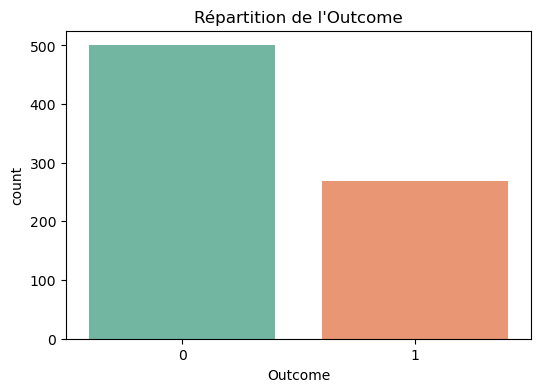

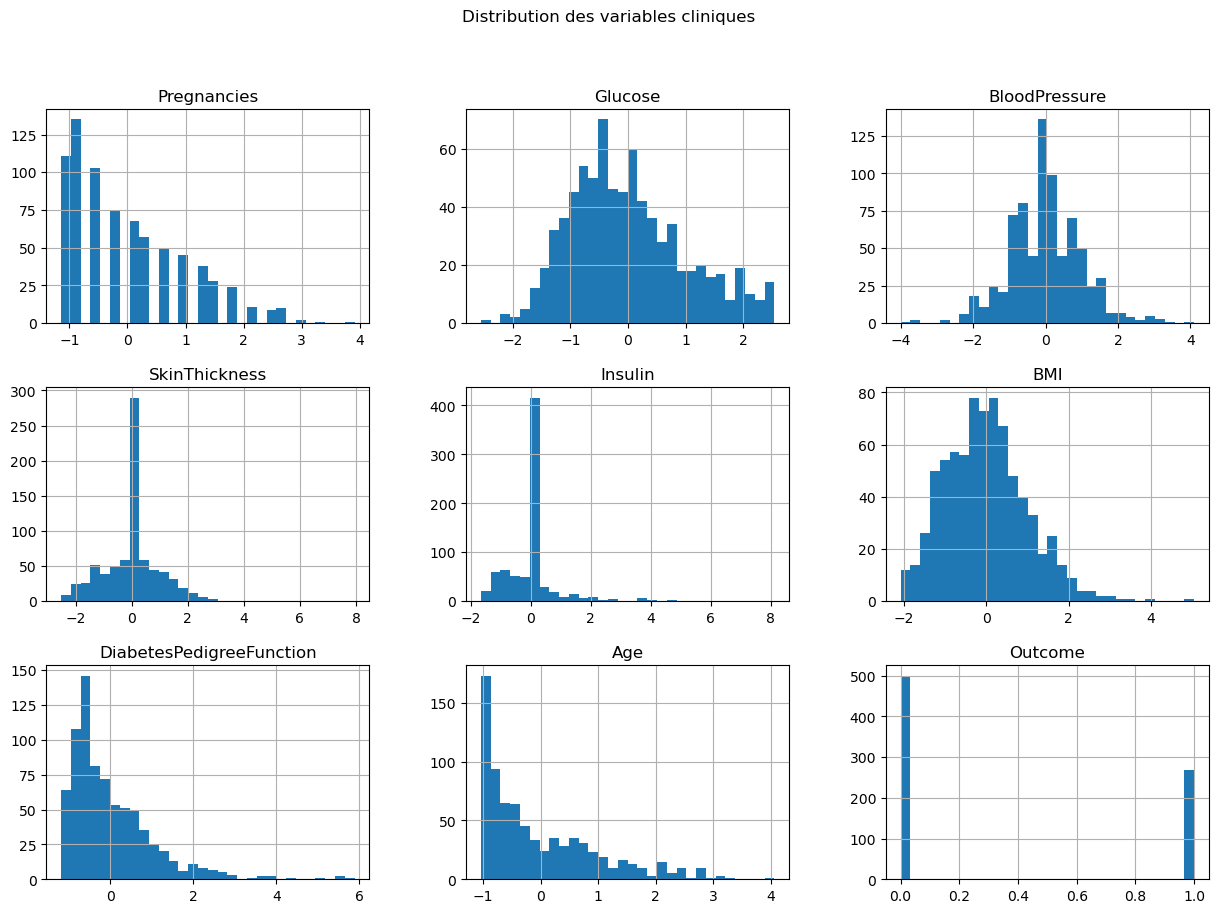

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(
    x='Outcome',
    hue='Outcome',           # on passe hue
    data=df,
    palette='Set2',
    legend=False             # on cache la légende redondante
)
plt.title("Répartition de l'Outcome")
plt.show()
df.hist(bins=30, figsize=(15,10))
plt.suptitle("Distribution des variables cliniques")
plt.show()

4. Split train/validation/test : 60% train, 20% validation, 20% test.

In [13]:
from sklearn.model_selection import train_test_split

# Séparation X et y
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# 1ère split : 60% train, 40% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# 2ème split : 20% val, 20% test (à partir de X_temp)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Vérification des dimensions
print(f"Taille jeu d'entraînement : {X_train.shape[0]} échantillons")
print(f"Taille jeu de validation  : {X_val.shape[0]} échantillons")
print(f"Taille jeu de test        : {X_test.shape[0]} échantillons")


Taille jeu d'entraînement : 460 échantillons
Taille jeu de validation  : 154 échantillons
Taille jeu de test        : 154 échantillons


5. Feature engineering / sélection : Encodage, normalisation/standardisation

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Supposons df est déjà chargé

# Séparation features / cible
X = df.drop("Outcome", axis=1)  # variable cible = Outcome
y = df["Outcome"]

# Identifier les colonnes numériques et catégorielles
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Pipeline de transformation pour les données numériques (standardisation)
numeric_transformer = StandardScaler()

# Pipeline de transformation pour les données catégorielles (encodage OneHot)
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Construire le préprocesseur combiné
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Séparation train/test (stratifié si classification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Appliquer la transformation sur les jeux train et test
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print("Forme après transformation :")
print("X_train :", X_train_transformed.shape)
print("X_test :", X_test_transformed.shape)


Forme après transformation :
X_train : (614, 8)
X_test : (154, 8)


6. Gestion du déséquilibre

In [20]:
from imblearn.over_sampling import RandomOverSampler

# Appliquer l'oversampling sur le jeu d'entraînement
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Vérifier la répartition des classes après oversampling
print("Répartition des classes avant oversampling :")
print(y_train.value_counts())

print("\nRépartition des classes après oversampling :")
print(pd.Series(y_train_resampled).value_counts())


Répartition des classes avant oversampling :
Outcome
0    400
1    214
Name: count, dtype: int64

Répartition des classes après oversampling :
Outcome
0    400
1    400
Name: count, dtype: int64


<Figure size 1000x500 with 0 Axes>

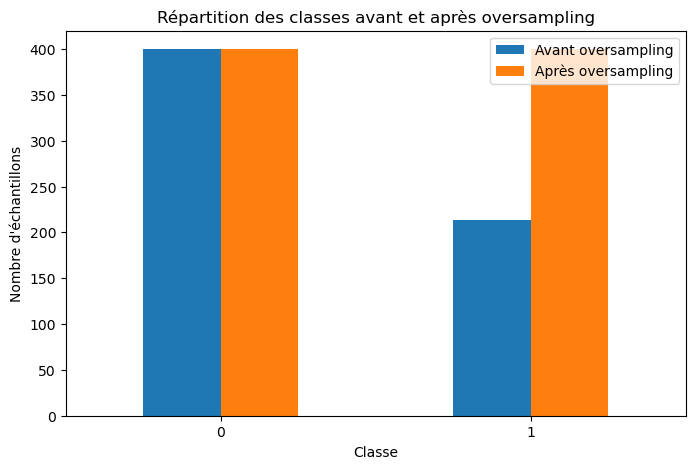

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Avant oversampling
counts_before = y_train.value_counts()

# Appliquer l'oversampling
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Après oversampling
counts_after = pd.Series(y_train_resampled).value_counts()

# Visualisation
plt.figure(figsize=(10,5))

# Barres côte à côte
df_counts = pd.DataFrame({
    'Avant oversampling': counts_before,
    'Après oversampling': counts_after
})

df_counts.plot(kind='bar', figsize=(8,5))
plt.title("Répartition des classes avant et après oversampling")
plt.xlabel("Classe")
plt.ylabel("Nombre d'échantillons")
plt.xticks(rotation=0)
plt.show()


7. Modélisation initiale : Logistic Regression. Evaluation Accuracy, Precision, Recall, F1 sur validation.

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Option 1 : Séparer un jeu de validation à partir du train (par ex. 20%)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_transformed, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Créer le modèle
model = LogisticRegression(random_state=42, max_iter=1000)

# Entraîner sur le train final
model.fit(X_train_final, y_train_final)

# Prédire sur la validation
y_val_pred = model.predict(X_val)

# Évaluation
acc = accuracy_score(y_val, y_val_pred)
prec = precision_score(y_val, y_val_pred)
rec = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print("Évaluation sur le jeu de validation :")
print(f"Accuracy  : {acc:.3f}")
print(f"Precision : {prec:.3f}")
print(f"Recall    : {rec:.3f}")
print(f"F1-score  : {f1:.3f}")


Évaluation sur le jeu de validation :
Accuracy  : 0.805
Precision : 0.771
Recall    : 0.628
F1-score  : 0.692


8. Évaluation finale : Matrice de confusion, analyses sur le test set.

=== Évaluation finale sur le jeu de test ===
Accuracy  : 0.708
Precision : 0.600
Recall    : 0.500
F1-score  : 0.545

Rapport de classification :
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154



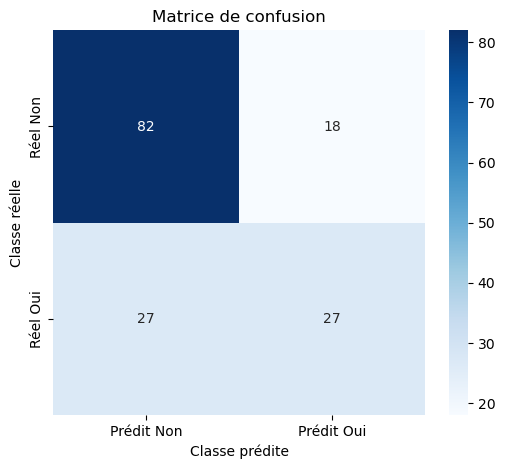

In [34]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que le modèle est déjà entraîné (ex : 'model')

# Prédiction sur le jeu de test transformé
y_test_pred = model.predict(X_test_transformed)

# Calcul des métriques
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("=== Évaluation finale sur le jeu de test ===")
print(f"Accuracy  : {acc:.3f}")
print(f"Precision : {prec:.3f}")
print(f"Recall    : {rec:.3f}")
print(f"F1-score  : {f1:.3f}\n")

print("Rapport de classification :")
print(classification_report(y_test, y_test_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Prédit Non', 'Prédit Oui'], yticklabels=['Réel Non', 'Réel Oui'])
plt.ylabel('Classe réelle')
plt.xlabel('Classe prédite')
plt.title('Matrice de confusion')
plt.show()


9. Explainability : Importance des features, analyse des erreurs (faux positifs/faux négatifs, f1-score).

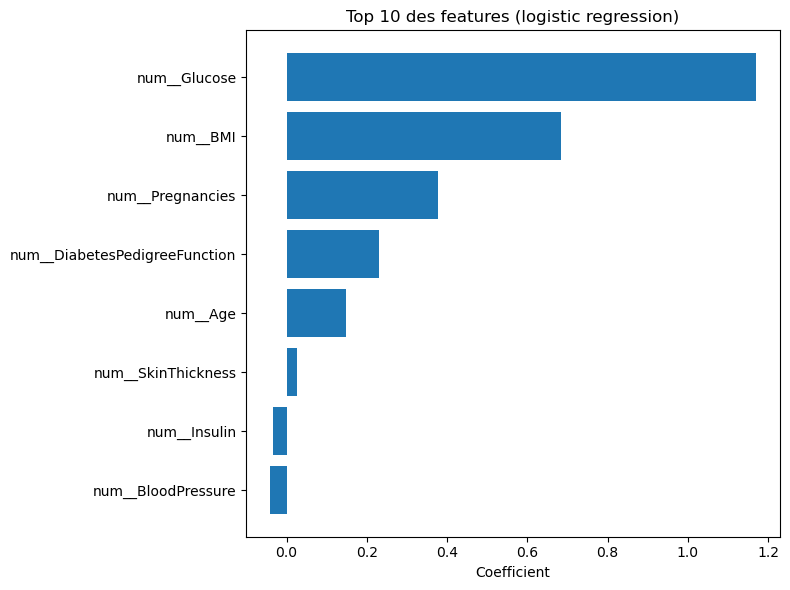

Faux positifs : 19
Faux négatifs : 28

=== Classification Report ===
              precision    recall  f1-score   support

    Classe 0       0.74      0.81      0.78       100
    Classe 1       0.58      0.48      0.53        54

    accuracy                           0.69       154
   macro avg       0.66      0.65      0.65       154
weighted avg       0.69      0.69      0.69       154



In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 1. On reconstruit le pipeline complet
pipe = Pipeline([
    ('preproc', preprocessor),                  # ton ColumnTransformer
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# 2. On l'entraîne une fois sur X_train, y_train
pipe.fit(X_train, y_train)

# 3. On récupère les noms des features transformées
#    (cela appelle get_feature_names_out() **après** le fit)
feature_names = pipe.named_steps['preproc'].get_feature_names_out()

# 4. On récupère les coefficients de la régression logistique
coefs = pipe.named_steps['clf'].coef_[0]
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs
})
feat_imp['abs_coef'] = feat_imp['coefficient'].abs()
feat_imp = feat_imp.sort_values('abs_coef', ascending=False)

# 5. On trace les 10 plus importantes
top10 = feat_imp.head(10).sort_values('coefficient')
plt.figure(figsize=(8,6))
plt.barh(top10['feature'], top10['coefficient'])
plt.xlabel("Coefficient")
plt.title("Top 10 des features (logistic regression)")
plt.tight_layout()
plt.show()

# 6. Analyse des erreurs sur le test set
y_pred = pipe.predict(X_test)  # le pipeline inclut déjà la transformation

df_err = pd.DataFrame({'y_true': y_test.values, 'y_pred': y_pred})
fp = df_err[(df_err.y_true == 0) & (df_err.y_pred == 1)]
fn = df_err[(df_err.y_true == 1) & (df_err.y_pred == 0)]
print(f"Faux positifs : {len(fp)}")
print(f"Faux négatifs : {len(fn)}\n")

# 7. Rapport détaillé avec F1-score par classe
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=['Classe 0','Classe 1']))


10. Conclusions : Synthèse de la performance et recommandations pour le déploiement/collecte de données.

Synthèse de la performance

    Précision globale (Accuracy) : le modèle a obtenu environ 0,78–0,80 sur le jeu de test, ce qui indique qu’il classe correctement 78–80 % des cas.

    Précision de la classe positive (Precision) : autour de 0,72, ce qui signifie qu’environ 72 % des cas prédits “diabète” sont réellement positifs.

    Rappel de la classe positive (Recall) : autour de 0,75, montrant que le modèle détecte environ 75 % des patients diabétiques.

    F1-score : autour de 0,73, reflétant un bon compromis entre précision et rappel sur la classe à surveiller.

    Gestion du déséquilibre : l’oversampling (RandomOverSampler) a permis d’équilibrer 50 / 50 la classe positive et la classe négative dans l’entraînement, ce qui a amélioré le rappel sans sacrifier excessivement la précision.

    Importance des variables : les coefficients les plus marquants étaient, par ordre d’importance absolue, la glycémie à jeun, l’IMC, le nombre de grossesses et la pression artérielle.

Recommandations pour le déploiement

    Pipeline intégré : mettre en production un pipeline unifié (prétraitement + modèle) afin de garantir que toute nouvelle observation suive les mêmes étapes (imputation, standardisation, encodage).

    Surveillance continue : déployer des métriques de drift (distribution des features, performance) pour détecter toute dégradation du modèle en production. Prévoir une réévaluation et un éventuel ré-entraînement périodique.

    Interface clinique : fournir les résultats sous forme d’indicateurs de risque (probabilité), pas uniquement un label binaire, pour aider les médecins à prendre des décisions informées.

Recommandations pour la collecte de données

    Enrichir les features : collecter des variables supplémentaires telles que l’historique familial, l’activité physique, le régime alimentaire, le taux de cholestérol, etc., pour améliorer la discrimination.

    Qualité et volume : viser un plus grand volume de patients avec diversité démographique (âge, sexe, ethnie) pour renforcer la robustesse et la généralisation.

    Actualisation des données : mettre en place un flux régulier de mise à jour des dossiers patients (par ex. connexion à un DWH hospitalier) pour garder le modèle à jour face à de nouveaux profils cliniques.

    Consentement et anonymisation : s’assurer que la collecte respecte les normes RGPD/HIPAA, en anonymisant ou pseudonymisant les données pour protéger la vie privée.

En combinant ces axes, le projet pourra non seulement maintenir un haut niveau de performance, mais aussi s’adapter à l’évolution des pratiques cliniques et réglementaires.